# 1D-CNN

Inspired by the second place solution of the Mechanisms of Action (MoA) Prediction Challange\footnote{https://www.kaggle.com/c/lish-moa/discussion/202256}, we develop a model that based on 1D convolutional layers. The dimensions of the input features are initially expanded to $2^{12}$ using a fully connected layer, followed by reshaping into segmented sequences. This procedure enables the model to have sufficient capacity to execute subsequential operations and learn patterns. Subsequently, four convolutional components are concatenated. A pooling operation is performed between the first two convolutional layers to decrease the dimensions of the hidden layer by consolidating the outputs of neuron clusters in the previous layer into a single neuron in the subsequent layer. The output of the second convolutional component is connected to the last convolutional layer through production as a shortcut mechanism.

In each convolutional component, the signal sequences are first batch normalized to enhance the training process's efficiency and stability by re-centring and re-scaling. The subsequential dropout layer helps avoid overfitting by scaling inputs not set to 0 up by $1/(1 - \text{rate})$ such that the sum over all inputs remains constant. A Rectified Linear Unit (ReLU) layer is chosen as the activation function. Similar to the 2D convolution, the key operation of the component, the computation of a neuron in a 1D convolution operation, can also be described as

$$
\hat{y}_{i,k} = B_k + \sum_{u=0}^{f_d-1} { \sum_{k'=0}^{f_{n'}-1} { x_{i',k'} \cdot w_{u,k',k} } } \ \text{with} \ i' = i \times s_d + u
$$

where

- $\hat{y}_{i,k}$ is the output of the neuron in position $i$ and feature map $k$ in the convolutional layer $l$
- $x_{i',k'}$ is the output of the neuron in position $i'$ and the convolutional layer $l-1$
- $B_k$ is the bias term for feature map $k$ in the convolutional layer $l$
- $s_d$ is the strides
- $f_d$ is the length of the strides
- $f_{n'}$ is the number of feature maps in the convolutional layer $l-1$
- $\cdot w_{u,k',k}$ is the connection weight between any neuron in feature map $k$ of the convolutional layer $l$ and its input located at position $u$ and feature map $k'$

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
from model.cnn1d.CNN1D import CNN1D
from model.abstractmodel import AbstractModel
from sklearn.metrics import mean_squared_error, r2_score
from ray import tune
import numpy as np

In [12]:
TRN = Dataset.load_csv("ds/exclude_CSD/TRN_All")
TST1 = Dataset.load_csv("ds/all/TST_1_All")
TST2 = Dataset.load_csv("ds/all/TST_2_All")

In [14]:
SPACE = {
    "weight_decay": tune.uniform(0, 1),
    "celu_alpha": tune.uniform(0, 1),
    "dropout": tune.uniform(0, 1),
    "conv2_1_dropout": tune.uniform(0, 1),
    "conv2_2_dropout": tune.uniform(0, 1),
    "decoder_dropout": tune.uniform(0, 1)
}

In [15]:
def trainable_func(config: dict, dataset: Dataset):
    trn, val = dataset.split()
    model = CNN1D(
        task_type="regression",
        n_tasks=1,
        dense_feats=2 ** 12,
        in_feats=TRN.X.shape[1],
        lr=0.001,
        weight_decay=config["weight_decay"],
        celu_alpha=config["celu_alpha"],
        dropout=config["dropout"],
        conv2_1_dropout=config["conv2_1_dropout"],
        conv2_2_dropout=config["conv2_2_dropout"],
        decoder_dropout=config["decoder_dropout"]
    )
    scores = model.fit(trn, val=val, epochs=150, verbose=False)
    tune.report(rmse=scores["val_rmse"][-1])

In [ ]:
from ray.tune.search import BasicVariantGenerator
from ray import tune, air

tunner = tune.Tuner(
    trainable=tune.with_parameters(trainable_func, dataset=TRN),
    param_space=SPACE,
    tune_config=tune.TuneConfig(
        num_samples=50,
        search_alg=BasicVariantGenerator(max_concurrent=1),
    ),
    run_config=air.RunConfig(
        progress_reporter=tune.JupyterNotebookReporter(
            parameter_columns=[],
            metric_columns=["rmse"]
        )
    )
)
tune_result = tunner.fit()

In [ ]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

In [ ]:
SPACE = {
    "weight_decay": tune.uniform(0, 1),
    "celu_alpha": tune.uniform(0.001, 1),
    "dropout": tune.uniform(0, 1),
    "conv2_1_dropout": tune.uniform(0, 1),
    "conv2_2_dropout": tune.uniform(0, 1),
    "decoder_dropout": tune.uniform(0, 1)
}

In [ ]:
def trainable_func(config: dict, dataset: Dataset):
    trn, val = dataset.split()
    model = CNN1D(
        task_type="regression",
        n_tasks=1,
        dense_feats=2 ** 12,
        in_feats=TRN.X.shape[1],
        lr=0.001,
        weight_decay=config["weight_decay"],
        celu_alpha=config["celu_alpha"],
        dropout=config["dropout"],
        conv2_1_dropout=config["conv2_1_dropout"],
        conv2_2_dropout=config["conv2_2_dropout"],
        decoder_dropout=config["decoder_dropout"]
    )
    scores = model.fit(trn, val=val, epochs=300, verbose=False)
    tune.report(rmse=scores["val_rmse"][-1])

In [ ]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search import ConcurrencyLimiter
from ray import tune, air

tunner = tune.Tuner(
    trainable=tune.with_parameters(trainable_func, dataset=TRN),
    param_space=SPACE,
    tune_config=tune.TuneConfig(
        num_samples=100,
        search_alg=ConcurrencyLimiter(BayesOptSearch(metric="rmse", mode="min"), max_concurrent=1),
    ),
    run_config=air.RunConfig(
        progress_reporter=tune.JupyterNotebookReporter(
            parameter_columns=[],
            metric_columns=["rmse"]
        )
    )
)
tune_result = tunner.fit()

In [ ]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

In [3]:
TRN = Dataset.load_csv("ds/2019trn/TRN_All")
TST1 = Dataset.load_csv("ds/all/TST_1_All")
TST2 = Dataset.load_csv("ds/all/TST_2_All")

In [10]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [11]:
AbstractModel.set_seed(4567)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = CNN1D(
        task_type="regression",
        n_tasks=1,
        dense_feats=2 ** 12,
        in_feats=TRN.X.shape[1],
        lr=0.01,
        weight_decay=0.32,
        celu_alpha=0.6,
        dropout=0.1,
        conv2_1_dropout=0.01,
        conv2_2_dropout=0.2,
        decoder_dropout=0.2
    )
    model.fit(trn, val=val, max_epochs=300, min_epochs=180, early_stop=20, batch_size=len(TRN))
    k_pred_tst1.append(model.predict(TST1, use_best_state=True))
    k_pred_tst2.append(model.predict(TST2, use_best_state=True))

[INFO] Expect to use '1D Tabular Data' to featurize SMILES


100%|██████████| 250/250 [00:03<00:00, 65.93it/s, loss: 0.300 val_loss: 0.617 val_rmse: 1.280]


[INFO] Expect to use '1D Tabular Data' to featurize SMILES


 90%|█████████ | 226/250 [00:03<00:00, 68.39it/s, loss: 0.447 val_loss: 0.804 val_rmse: 1.505]


[INFO] Expect to use '1D Tabular Data' to featurize SMILES


 98%|█████████▊| 244/250 [00:03<00:00, 69.33it/s, loss: 0.289 val_loss: 0.818 val_rmse: 1.529]


[INFO] Expect to use '1D Tabular Data' to featurize SMILES


 89%|████████▉ | 222/250 [00:03<00:00, 68.29it/s, loss: 0.384 val_loss: 0.559 val_rmse: 1.346]


[INFO] Expect to use '1D Tabular Data' to featurize SMILES


 83%|████████▎ | 207/250 [00:03<00:00, 68.81it/s, loss: 0.614 val_loss: 1.145 val_rmse: 1.869]


In [12]:
pred_tst1 = np.mean(np.concatenate(k_pred_tst1, axis=1), axis=1)
pred_tst2 = np.mean(np.concatenate(k_pred_tst2, axis=1), axis=1)

In [195]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : RMSE 0.8040435316280928
TST2 : RMSE 1.284497316207898
TST1 : R^2 0.5965646629501995
TST2 : R^2 0.6402992356319162


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (1D-CNN)\nRMSE: 1.284, $R^2$: 0.640')

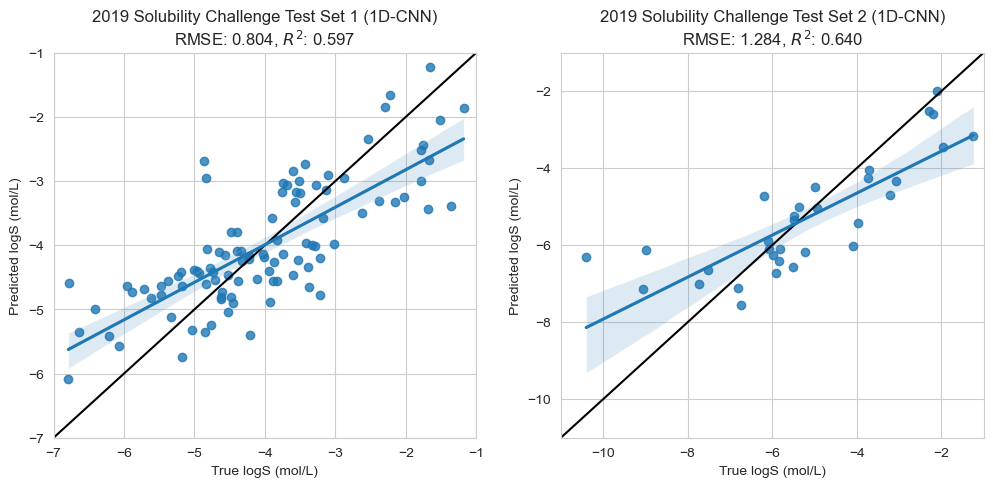

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model_name = "1D-CNN"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1.reshape(-1)
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2.reshape(-1)
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")